# **Import Library**

In [1]:
import numpy as np
import pandas as pd
import csv
import scipy.io
import json
from datetime import datetime,timedelta
import xgboost as xgb
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Reading data for the device 36 run 1**

In [2]:
mat_data = scipy.io.loadmat('/kaggle/input/mosfets-dataset/Test_36_run_1.mat')
transient=mat_data['measurement']['transient']
steady=mat_data['measurement']['steadyState']

# **Extracted data from transient file**

In [3]:
temp = transient[0][0][0]
gateSignalVoltage = [[] for _ in range(len(temp))]
gateSourceVoltage = [[] for _ in range(len(temp))]
drainSourceVoltage = [[] for _ in range(len(temp))]
drainCurrent = [[] for _ in range(len(temp))]
date = []
nanosec_time =[]

for i in range(len(temp)):
    date.append(temp[i][0][0])
    nanosec_time.append(temp[i][1][0][0])
    for j in range(500):
        gateSignalVoltage[i].append(temp[i][3][0][0][1][0][j])
        gateSourceVoltage[i].append(temp[i][3][0][0][2][0][j])
        drainSourceVoltage[i].append(temp[i][3][0][0][3][0][j])
        drainCurrent[i].append(temp[i][3][0][0][4][0][j])

# Gate control, VDS, and ID signals during one transient phase at the beginning of its life-cycle

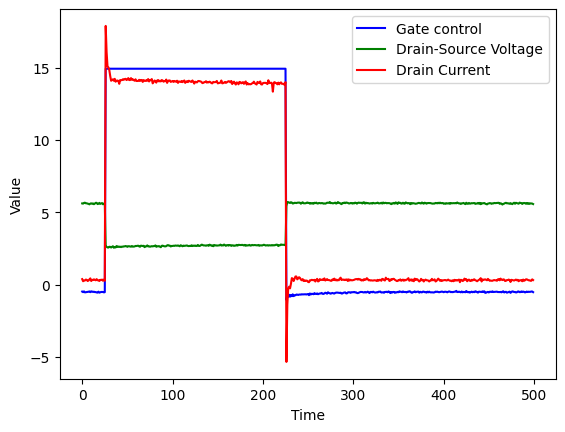

In [4]:
time = np.arange(0, 500, 1)
value1 = np.array(gateSignalVoltage[0])
value2 = np.array(drainSourceVoltage[0])
value3 = np.array(drainCurrent[0])

plt.plot(time, value1, label='Gate control', color='blue')
plt.plot(time, value2, label='Drain-Source Voltage', color='green')
plt.plot(time, value3, label='Drain Current', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


# Gate control, VDS, and ID signals during one transient phase at the end of its life-cycle

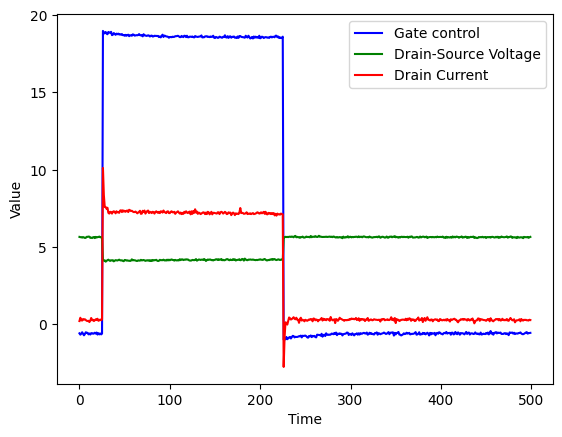

In [5]:
time = np.arange(0, 500, 1)
value1 = np.array(gateSignalVoltage[10000])
value2 = np.array(drainSourceVoltage[10000])
value3 = np.array(drainCurrent[10000])

plt.plot(time, value1, label='Gate control', color='blue')
plt.plot(time, value2, label='Drain-Source Voltage', color='green')
plt.plot(time, value3, label='Drain Current', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


# ****Calculated the time and resistance for each example****

In [6]:
Rds = [[] for _ in range(len(temp))]
aging_time = [[] for _ in range(len(temp))]
dt = 0
for i in range(len(nanosec_time)):
    
    if i != len(nanosec_time) - 1 :
        dt = nanosec_time[i+1] - nanosec_time[i]
    else:
        dt = nanosec_time[i]

    microseconds_to_add = ( np.abs(dt) / 500 ) * 1000000
    date_format = "%m/%d/%Y %H:%M:%S.%f"
    date_object = datetime.strptime(date[i] , date_format)
    time_to_add = timedelta(microseconds = microseconds_to_add)
    new_time = date_object
    for j in range(500):
        Rds[i].append(drainSourceVoltage[i][j] / drainCurrent[i][j])
        aging_time[i].append(new_time)
        new_time += time_to_add

# **Deleted values where gate is off**

In [7]:
R=[]
aging=[]
for i in range(len(gateSignalVoltage)):
    #mean=sum(gateSignalVoltage[i]) / len(gateSignalVoltage[i])
    mean = (max(gateSignalVoltage[i]) + min(gateSignalVoltage[i])) / 2

    for j in range(500):
        if gateSignalVoltage[i][j] > mean:
            R.append(Rds[i][j])
            aging.append(aging_time[i][j])
        

# **Extracted data from steady file**

In [8]:
temp = steady[0][0][0]
package_temperature = []
flange_temperature = []
date_temperature = []
dsvs = []
dcs = []
for i in range(len(temp)):
    date_object = datetime.strptime(temp[i][0][0] , date_format)
    date_temperature.append(date_object)
    package_temperature.append(temp[i][3][0][0][1][0][0])
    flange_temperature.append(temp[i][3][0][0][4][0][0])
    dsvs.append(temp[i][3][0][0][2][0][0])
    dcs.append(temp[i][3][0][0][3][0][0])

# Plot the temperature change with respect to time

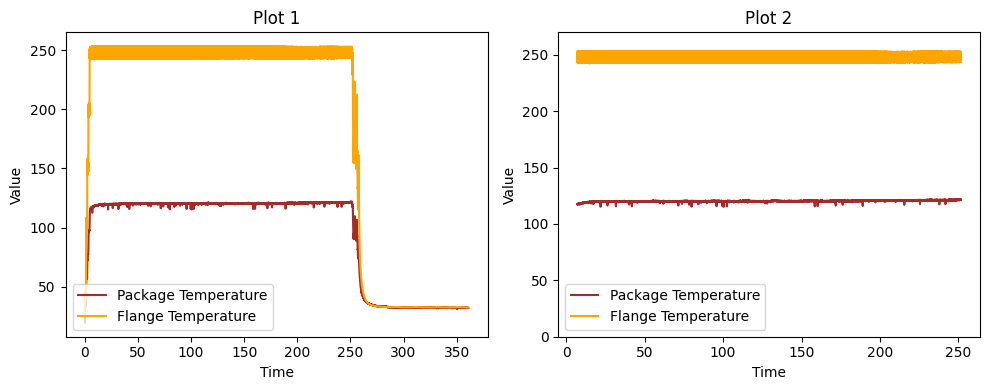

In [9]:
first_index_ = 1050
last_index_ = 37144
time1 = np.array([(t - date_temperature[0]).total_seconds()  / 60 for t in date_temperature])
time2 = [(t - date_temperature[0]).total_seconds()  / 60 for t in date_temperature[first_index_:last_index_]]
value1 = package_temperature
value2 = flange_temperature

fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
ax1.plot(time1, value1, label='Package Temperature', color='brown')
ax1.plot(time1, value2, label='Flange Temperature', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

ax2 = plt.subplot(gs[1])
ax2.set_ylim(0, 270)
ax2.plot(time2, value1[first_index_:last_index_], label='Package Temperature', color='brown')
ax2.plot(time2, value2[first_index_:last_index_], label='Flange Temperature', color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

plt.tight_layout()
plt.show()


# Deleted values outside the required temperature range

In [10]:
first_norm = date_temperature[first_index_]
last_norm = date_temperature[last_index_]
first_index = 0
first_threshold = 1e12
last_index = 0
last_threshold = 1e12

for i in range(len(aging)-1 ,0 , -1):
    
    first_time_difference = np.abs((aging[i] - first_norm).total_seconds() * 1e6 )
    if first_time_difference < first_threshold:
        first_threshold = first_time_difference
        first_index = i
        
    last_time_difference = np.abs((aging[i] - last_norm).total_seconds() * 1e6 )
    if last_time_difference < last_threshold:
        last_threshold = last_time_difference
        last_index = i
        
print(first_index)
print(first_threshold)
print(last_index)
print(last_threshold)

92999
218950.0
4422600
25096.0


# Regression model Training for temperature change with time

In [11]:
from sklearn.model_selection import train_test_split
X = np.array([(t - date_temperature[first_index_]).total_seconds() *1e6   for t in date_temperature[first_index_:last_index_]]).reshape(-1, 1)
y = np.array(package_temperature[first_index_:last_index_])

X_train , X_test , y_train , y_test = train_test_split(X, y, random_state=104,test_size=0.25,shuffle=True) 


# Linear Regression

Train (MSE): 0.09983085652781824
Test (MSE): 0.10067968789010327


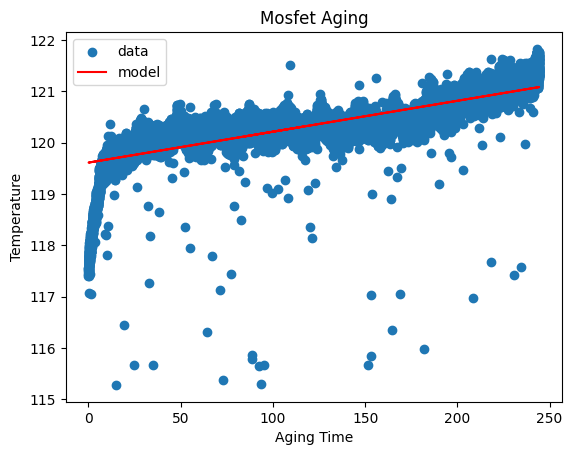

In [12]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)


y_pred = linear_model.predict(X_train)
mse = mean_squared_error(y_train , y_pred)
print(f"Train (MSE): {mse}")


y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test , y_pred)
print(f"Test (MSE): {mse}")

#plt.xlim(0, 250)
plt.scatter(X /60e6  , y , label="data")
plt.plot(X_test / 60e6  , y_pred, color="red", label="model")
plt.xlabel('Aging Time')
plt.ylabel('Temperature')
plt.title('Mosfet Aging')
plt.legend()
plt.show()

# Xgbost Regression

Train (MSE): 0.019225140033769763
Test (MSE): 0.02700029774642935


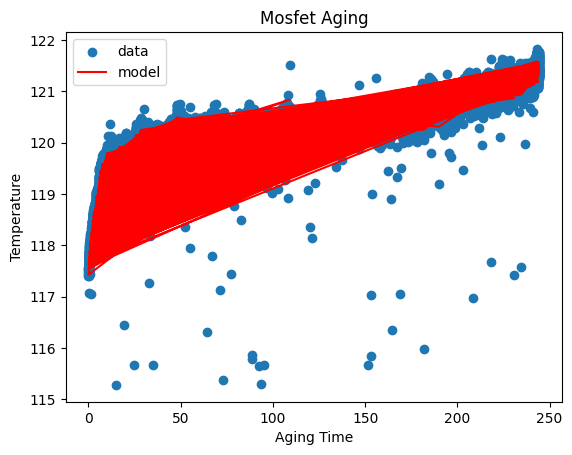

In [13]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print(f"Train (MSE): {mse}")


y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test , y_pred)
print(f"Test (MSE): {mse}")

plt.scatter(X /60e6  , y , label="data")
plt.plot(X_test / 60e6  , y_pred, color="red", label="model")
plt.xlabel('Aging Time')
plt.ylabel('Temperature')
plt.title('Mosfet Aging')
plt.legend()
plt.show()

# Calculating resistance in the steady file

In [14]:
Rds_steady = []
for i in range(len(dcs)):
    Rds_steady.append(dsvs[i] / dcs[i])

# Display the change of resistance with temperature

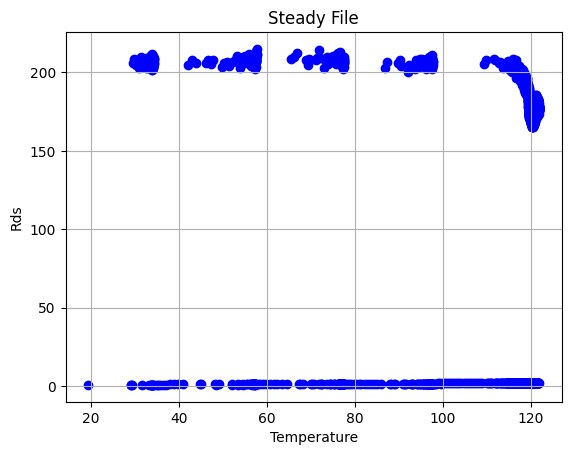

In [15]:
x = package_temperature[0:37144]
y = Rds_steady[0:37144]

plt.scatter(x, y, color='b', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Rds')
plt.title('Steady File')
plt.grid(True)
plt.show()

# Deleted high resistance values

In [16]:
r_two = []
f_two = []

for i in range(len(Rds_steady[0:37144])):
    if Rds_steady[ i] < 20 : 
        r_two.append(Rds_steady[i])
        f_two.append(x[i])
    

X = np.array(r_two).reshape(-1,1)
y = np.array(f_two)

X_train , X_test , y_train , y_test = train_test_split(X, y, random_state=104,test_size=0.25,shuffle=True) 


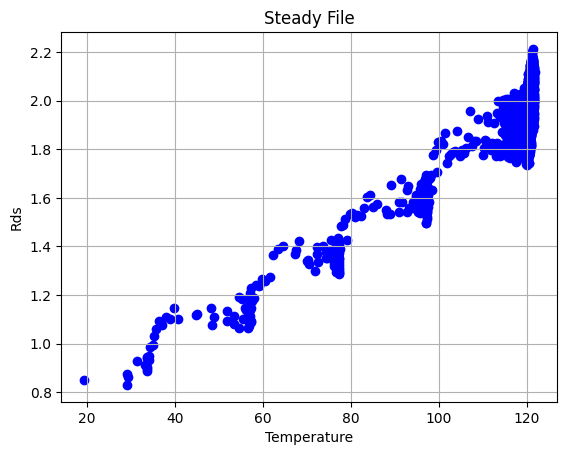

In [17]:
plt.scatter(f_two , r_two, color='b', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Rds')
plt.title('Steady File')
plt.grid(True)
plt.show()

# Normalization of resistance values

In [18]:
max_value = max(r_two)
min_value = min(r_two)
R_norm = [(x - min_value) / (max_value - min_value) for x in r_two]

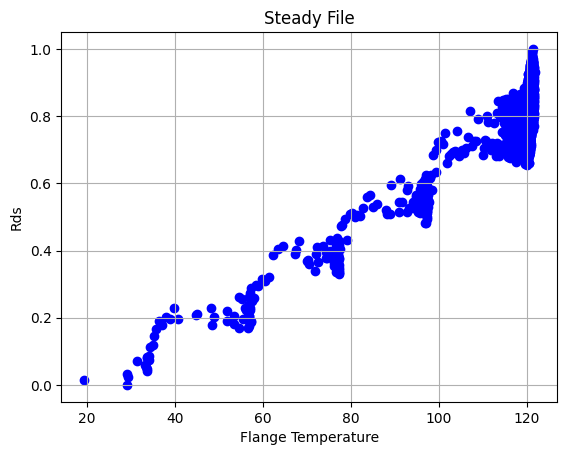

In [19]:
plt.scatter(f_two , R_norm, color='b', marker='o')
plt.xlabel('Flange Temperature')
plt.ylabel('Rds')
plt.title('Steady File')
plt.grid(True)
plt.show()

# training model for that

In [20]:
X = np.array(f_two).reshape(-1, 1)
y = np.array(R_norm)
X_train , X_test , y_train , y_test = train_test_split(X, y, random_state=104,test_size=0.25,shuffle=True) 

Train (MSE): 0.0017809693525052649
Test (MSE): 0.0021101850543023227


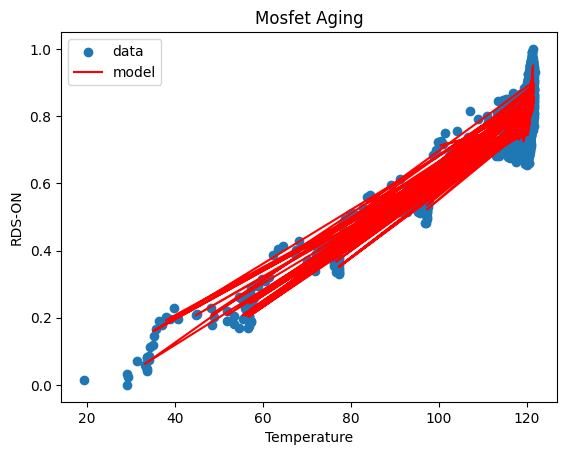

In [21]:
R_xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
R_xgb_model.fit(X_train, y_train)


y_pred = R_xgb_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print(f"Train (MSE): {mse}")


y_pred = R_xgb_model.predict(X_test)
mse = mean_squared_error(y_test , y_pred)
print(f"Test (MSE): {mse}")

plt.scatter(X  , y , label="data")
plt.plot(X_test  , y_pred, color="red", label="model")
plt.xlabel('Temperature')
plt.ylabel('RDS-ON')
plt.title('Mosfet Aging')
plt.legend()
plt.show()

# Calculated the ultimate resistance

In [22]:
R_final = []
for i in range(first_index + 1 , last_index , 10 ):
    if i%1000000 == 0 :
        print(i)
    temp_time = (aging[i] - date_temperature[first_index_]).total_seconds() * 1e6 
    T = xgb_model.predict(temp_time)
    temp_R= R_xgb_model.predict(T)
    R_final.append(temp_R)

/opt/conda/lib/python3.10/site-packages/xgboost/data.py:925: UserWarning: Unknown data type: <class 'float'>, trying to convert it to csr_matrix
  warnings.warn(


1000000
2000000
3000000
4000000


In [23]:
TTT = []
for i in range(0,len(R_final)):
    TTT.append(R_final[i] - R_final[0])

# Aging time chart

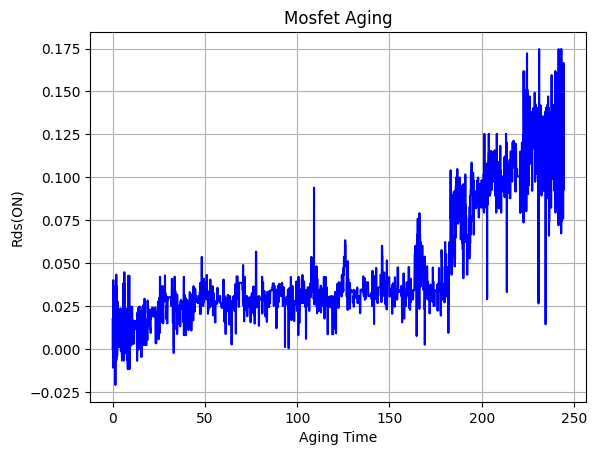

In [24]:
time_numeric = np.array([(t - date_temperature[first_index_]).total_seconds() *1e6 for t in aging[first_index+1:last_index:10]])

plt.plot(time_numeric / 60e6 , TTT , linestyle='-', color='b')
plt.xlabel('Aging Time')
plt.ylabel('Rds(ON)')
plt.title('Mosfet Aging')
plt.grid(True)
plt.show()

In [25]:
df = pd.DataFrame({'Delta-Rds-ON': R_final, 'Aging-Time': time_numeric})
df.to_csv('mosfet_36.csv', index=False)

In [26]:
df.head()

,Delta-Rds-ON,Aging-Time
0,[0.7514313],883300.0
1,[0.7514313],888800.0
2,[0.7514313],894300.0
3,[0.7514313],899800.0
4,[0.7514313],905300.0
